In [2]:
import requests
from bs4 import BeautifulSoup
import re
from urllib.parse import urlparse
from datetime import datetime
import pandas as pd
import time
from scraper_utils import scrape_and_enrich
import seaborn as sns
import matplotlib.pyplot as plt

## Compile Scrapped Data

### gossip

In [3]:
# Scrapped from gossipcop_fake.csv
gossiped_fake = pd.read_csv('./dataset/gossip_fake_with_article_text.csv')
gossiped_fake["news_type"] = "gossip"
gossiped_fake["class"] = 0
gossiped_fake.head()

,id,news_url,title,tweet_ids,extracted_article_text,news_type,class
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,"By CAITLYN HITT Published: 15:58 BST, 22 June ...",gossip,0
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,[Error fetching URL: HTTP error 404 for https:...,gossip,0
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,By Variety Staff Follow Us on Twitter Thousand...,gossip,0
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,By CARLY STERN FOR DAILYMAIL.COM and JJ NATTRA...,gossip,0
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,By Variety Staff Follow Us on Twitter Oscar no...,gossip,0


In [4]:
# Scrapped from gossipcop_real.csv
gossiped_real = pd.read_csv('./dataset/gossip_real_with_article_text.csv')
gossiped_real["news_type"] = "gossip"
gossiped_real["class"] = 1
gossiped_real[['title', 'extracted_article_text', 'news_type', 'class']].head()

,title,extracted_article_text,news_type,class
0,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,"91 years of expert advice and inspiration, for...",gossip,1
1,Kylie Jenner refusing to discuss Tyga on Life ...,By ROSS MCDONAGH FOR DAILYMAIL.COM Published: ...,gossip,1
2,Quinn Perkins,"Quinn Perkins, formerly Lindsay Dwyer, is a fi...",gossip,1
3,I Tried Kim Kardashian's Butt Workout & Am For...,"A community celebrating Black voices, Black ar...",gossip,1
4,Celine Dion donates concert proceeds to Vegas ...,[Error fetching URL: Connection error for http...,gossip,1


In [5]:
# Combine gossip dataset
gossip = pd.concat([gossiped_fake, gossiped_real], ignore_index=True)
gossip = gossip.sample(frac = 1, random_state=42).reset_index(drop=True)
gossip = gossip[['title', 'extracted_article_text', 'news_type', 'class']]
gossip.head()

,title,extracted_article_text,news_type,class
0,Is Liam Hemsworth Mad At Miley Cyrus For Texti...,Liam Hemsworth is NOT “livid” about Miley Cyru...,gossip,0
1,Sports Illustrated reveals 2018 Swimsuit cover...,[Error fetching URL: HTTP error 404 for https:...,gossip,1
2,Married at First Sight (Australian TV series),Married at First Sight is an Australian realit...,gossip,1
3,How to Recreate Margot Robbie’s Bent Hair From...,[Error fetching URL: HTTP error 403 for http:/...,gossip,1
4,Dakota Johnson had to teach Jamie Dornan how t...,[Error fetching URL: HTTP error 404 for http:/...,gossip,1


In [6]:
# Check shape before dropping entries whose article text couldn't be scrapped
gossip.shape

(21871, 4)

In [7]:
# Define the patterns to match
error_patterns = [
    r'^\[Error fetching URL:.*',  # Match starting with "[Error fetching URL:"
    r'^\[No substantial text found or page structure is unusual for.*'  # Match starting with "[No substantial text found or page structure is unusual for"
]
# Count initial number of rows
initial_rows = len(gossip)

# Drop rows where 'extracted_article_text' matches any of the error patterns
gossip = gossip[
    ~gossip['extracted_article_text'].str.match('|'.join(error_patterns), na=False)
].reset_index(drop=True)
gossip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15504 entries, 0 to 15503
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   title                   15504 non-null  object
 1   extracted_article_text  15504 non-null  object
 2   news_type               15504 non-null  object
 3   class                   15504 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 484.6+ KB


In [8]:
gossip['class'].value_counts()

class
1    12029
0     3475
Name: count, dtype: int64

### political

In [9]:
# Scrapped from politifact_fake.csv
political_fake = pd.read_csv('./dataset/politifact_fake_with_article_text.csv')
political_fake["news_type"] = "political"
political_fake["class"] = 0
political_fake[['title', 'extracted_article_text', 'news_type', 'class']].head()

,title,extracted_article_text,news_type,class
0,BREAKING: First NFL Team Declares Bankruptcy O...,[Error fetching URL: HTTP error 404 for https:...,political,0
1,Court Orders Obama To Pay $400 Million In Rest...,[Error fetching URL: Connection error for http...,political,0
2,UPDATE: Second Roy Moore Accuser Works For Mic...,Pkv Games adalah salah satu provider judi onli...,political,0
3,Oscar Pistorius Attempts To Commit Suicide,[Error fetching URL: HTTP error 404 for https:...,political,0
4,Trump Votes For Death Penalty For Being Gay,Ready or Not Los Suenos Stories RUNE Free Down...,political,0


In [10]:
# Scrapped from politifact_real.csv
political_real = pd.read_csv('./dataset/politifact_real_with_article_text.csv')
political_real["news_type"] = "political"
political_real["class"] = 1
political_real[['title', 'extracted_article_text', 'news_type', 'class']].head()

,title,extracted_article_text,news_type,class
0,National Federation of Independent Business,[No substantial text found or page structure i...,political,1
1,comments in Fayetteville NC,CQ Username Password Stay signed in Forgot you...,political,1
2,"Romney makes pitch, hoping to close deal : Ele...",Photo by Matt McClain Governor Mitt Romney stu...,political,1
3,Democratic Leaders Say House Democrats Are Uni...,Transcript of Press Availability After House D...,political,1
4,"Budget of the United States Government, FY 2008",The President’s 2008 Budget addresses the Nati...,political,1


In [11]:
# Combine political dataset
political = pd.concat([political_fake, political_real], ignore_index=True)
political = political.sample(frac = 1, random_state=42).reset_index(drop=True)
political = political[['title', 'extracted_article_text', 'news_type', 'class']]
political.head()

,title,extracted_article_text,news_type,class
0,Transcripts,[Error fetching URL: General request error for...,political,1
1,National Income and Product Accounts Table 175...,[Error fetching URL: HTTP error 404 for http:/...,political,1
2,"Saudi Arabia Energy Data, Statistics and Analysis",[No substantial text found or page structure i...,political,1
3,"If Democrats Lose, Blame These Guys",[Error fetching URL: HTTP error 403 for http:/...,political,1
4,FY 2010 President's Budget,Historical Tables provides data on budget rece...,political,1


In [12]:
# Check shape before dropping entries whose article text couldn't be scrapped
political.shape

(995, 4)

In [13]:
# Define the patterns to match
error_patterns = [
    r'^\[Error fetching URL:.*',  # Match starting with [Error fetching URL:
    r'^\[No substantial text found or page structure is unusual for.*'  # Match starting with [No substantial text found or page structure is unusual for
]
# Count initial number of rows
initial_rows = len(political)

# Drop rows where 'extracted_article_text' matches any of the error patterns
political = political[
    ~political['extracted_article_text'].str.match('|'.join(error_patterns), na=False)
].reset_index(drop=True)
political.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   title                   540 non-null    object
 1   extracted_article_text  540 non-null    object
 2   news_type               540 non-null    object
 3   class                   540 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 17.0+ KB


In [14]:
political['class'].value_counts()

class
1    346
0    194
Name: count, dtype: int64

### Combine political and gossip 

In [15]:
# Combine political and gossip datasets
data = pd.concat([political, gossip], ignore_index=True)
data = data.sample(frac = 1, random_state=42).reset_index(drop=True)
data.head(10)

,title,extracted_article_text,news_type,class
0,Will 'The Royals' Return For Season 5? This St...,Entertainment With a royal wedding and a coup ...,gossip,1
1,Naya Rivera refiles for divorce from Ryan Dors...,"This material may not be published, broadcast,...",gossip,1
2,Outfit ideas for Taylor Swift's Reputation Tour,United By Pop - United Kingdom. United States....,gossip,1
3,Scott Hutchison Dead: Frightened Rabbit Frontm...,By Robert Mitchell A body found Thursday night...,gossip,1
4,Kate Middleton Gives Birth to Royal Baby No. 3...,Baby No. 3 is officially here! Kate Middleton ...,gossip,1
5,Khloe Kardashian: True Has 'Baby Class Once a ...,"""It's so fun to see how they all interact and ...",gossip,0
6,Lena Dunham Mourns the Death of Her Cat Gia Ma...,Lena Dunham's beloved cat Gia Marie died in he...,gossip,1
7,Tim McGraw collapses on stage in Ireland,Country star Tim McGraw collapsed on stage dur...,gossip,1
8,Star Wars Fans Show Up for 'Solo' Red Carpet i...,Hollywood Boulevard was shutdown at Highland T...,gossip,1
9,Jessica Simpson insists she's not pregnant on ...,By DAILYMAIL.COM REPORTER Published: 14:49 BST...,gossip,1


In [25]:
data.iloc[99, 1]

'Looks like Blac Chyna and "hot felon" Jeremy Meeks may have something in the works together. Chyna shared a picture of the two posing with their arms around one another on Snapchat on Wednesday night, both showing off their tattoos. Chyna donned a skintight lace-up orange dress, while Meeks kept it casual in a camouflage-print shirt and ripped jeans. News In earlier Snapchat posts, Chyna appears to be at a photo shoot, leading some to speculate the two are possibly starring in a campaign together. Meeks, who became a model after his attractive mugshot went viral in 2014, has made headlines this summer due to his relationship with Topshop heiress Chloe Green. Meeks was photographed kissing Green on a luxury yacht just off the coast of Turkey in July, though he was still married to his wife, Melissa, at the time. Shortly after the pictures surfaced, Meeks filed for separation from Melissa, after eight years of marriage. News Since then, Meeks and Green haven\'t been shy about packing on

In [17]:
# Check shape of working dataset
data.shape

(16044, 4)

In [18]:
data['news_type'].value_counts()

news_type
gossip       15504
political      540
Name: count, dtype: int64

In [19]:
data['class'].value_counts()

class
1    12375
0     3669
Name: count, dtype: int64

In [20]:
# Export scrapped data to .csv
data.to_csv('./dataset/data.csv', index=False)

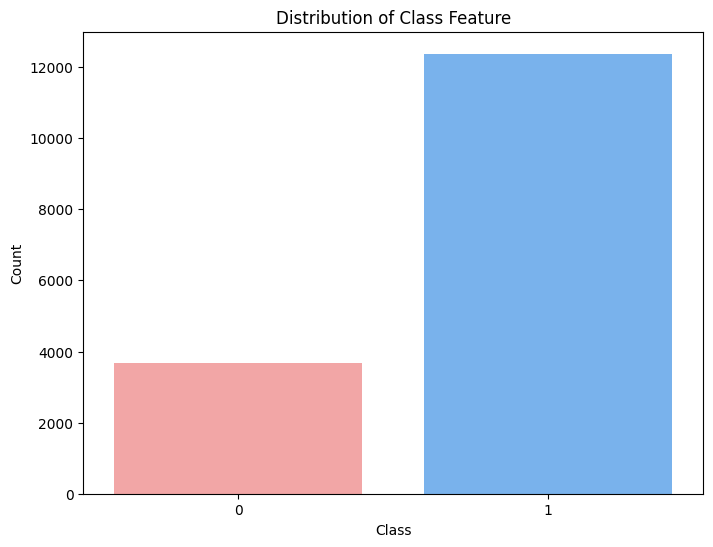

In [21]:
# Visualize distribuction based on class (0 = fake, 1 = real)
plt.figure(figsize=(8, 6))
sns.barplot(x='class', y='class', data=data, estimator=len, hue='class', palette=['#FF9999', '#66B2FF'], legend=False)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Class Feature')

# Display the plot
plt.show()